In [1]:
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab 

In [219]:
pd.set_option('display.max_columns', None)

def linear_regression(X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    b = np.linalg.inv(X.T@X)@X.T@y
    return b

def rmse(slopes, X_test, y_test):
    X_test = pd.get_dummies(X_test, drop_first = True)._get_numeric_data().values
    intercept_col = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)
    X_test = np.hstack((intercept_col, X_test))
    
    y_val_pred = X_test @ b
    y_val = y_test.values
    return np.sqrt(((y_val - y_val_pred) ** 2).mean())
    
def train_test_split(frac, X, response = 'Volume Sold (Gallons)'):
    X_train = X.sample(frac = frac)
    X_test = X.drop(X_train.index, axis = 0)
    

    y_train = X_train[response]
    X_train = X_train.drop(['County','Area Name',response], axis = 1)
    
   
    y_test = X_test[response]
    X_test = X_test.drop(['County','Area Name',response], axis = 1)
    
    
    return X_train,X_test, y_train, y_test

def r2(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    
    y_val_pred = X @ b
    ss_res = ((y - y_val_pred) ** 2).sum()
    return 1 - (ss_res/ss_tot)

def qqplot(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    y_val_pred = X @ b

    stats.probplot(y - y_val_pred, dist="norm", plot=pylab)
    pylab.show()
def resid_vs_fit(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    y_val_pred = X @ b
    resid = y - y_val_pred
    plt.scatter(y_val_pred, resid)
    plt.show()
    
def aic(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    y_val_pred = X @ b
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    ss_res = ((y - y_val_pred) ** 2).sum()
    sigmasq = ss_tot / X.shape[0]
    p = X.shape[1]
    
    return (ss_res + 2 *(p * sigmasq)) / ss_tot

def bic(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    y_val_pred = X @ b
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    ss_res = ((y - y_val_pred) ** 2).sum()
    sigmasq = ss_tot / X.shape[0]
    p = X.shape[1]
    n = X.shape[0]
    
    return (ss_res + (np.log(n) * p * sigmasq)) / ss_tot

def adj_r2(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    
    y_val_pred = X @ b
    ss_res = ((y - y_val_pred) ** 2).sum()
    
    r2 = 1 - (ss_res/ss_tot)
    return 1 - (((1 - r2) * (X.shape[0] - 1)) / (X.shape[0] - X.shape[1] - 1))

def cross_validation(X, y, k):
    rmses = []
    index_array = list(X.index)
    np.random.shuffle(index_array)
    index_folds = np.array_split(index_array, 5)
    for i in range(k):
        training_index = np.concatenate(index_folds[:i] + index_folds[(i+1):])
        test_index = index_folds[i]
        X_train = X.loc[training_index]
        y_train = y.loc[training_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        b = linear_regression(X_train, y_train)
        rmses.append(rmse(b, X_test, y_test))
    return np.mean(rmses)

In [3]:
df = pd.read_csv("../data/iowaliquor.csv")
df_sample = pd.read_csv("../data/iowa-sample.csv")
df_pop = pd.read_csv("../data/County_Population_in_Iowa_by_Year.csv")


/Users/anishyakkala/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
df_raw_employment = pd.read_csv("../data/Iowa_Quarterly_Census_of_Employment_and_Wage_data__Statewide_and_County_.csv")
df_raw_employment.fillna(0)
df_raw_employment["Area Name"] = df_raw_employment["Area Name"].str.lower()

In [78]:
df_employement = pd.pivot_table(df_raw_employment,
               index = ["Year", "Quarter", "Area Name"],
               values = ["Average Emp", "Wages"],
               aggfunc = np.sum
              ).reset_index()

In [80]:
df_employement = df_employement.merge(pd.pivot_table(df_raw_employment,
                                       index = ["Year", "Quarter", "Area Name"],
                                       values = ["Average Wage"],
                                       aggfunc = np.mean
                                      ).reset_index(),
                                        'inner')

In [81]:
df_employement["Year"] = df_employement["Year"].astype('str')
df_employement["Quarter"] = df_employement["Quarter"].astype('str')

In [159]:
df.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Quarter
0,S08096000008,10/04/2012,4641,Kum & Go #573 / SE 14th DM,5830 SE 14th ST,DES MOINES,50315,NaN,77.0,polk,1022100.0,TEQUILA,395.0,Proximo,89191,Jose Cuervo Especial Reposado Tequila Mini,12,500,11.50,17.25,1,17.25,0.50,0.13,2012,4
1,S23102300041,12/20/2014,4346,Roy's Foodland,105 PEARL ST,SHELLSBURG,52332,POINT (-91.869285 42.094155),6.0,benton,1012100.0,CANADIAN WHISKIES,115.0,"Constellation Wine Company, Inc.",11774,Black Velvet,24,375,3.07,4.61,6,27.66,2.25,0.59,2014,4
2,S14410500035,09/09/2013,3628,Wal-Mart 1528 / Cedar Rapids,2645 BLAIRS FERRY RD NE,CEDAR RAPIDS,52402,POINT (-91.680734 42.034748),57.0,linn,1062300.0,FLAVORED RUM,260.0,Diageo Americas,43410,Captain Morgan Parrot Bay Coconut,12,750,7.49,11.23,12,134.76,9.00,2.38,2013,3
3,S09427600021,12/12/2012,4708,No Frills Supermarkets #803 / Glenwo,423 SHARP ST,GLENWOOD,51534,POINT (-95.742987 41.04635),65.0,mills,1011100.0,BLENDED WHISKIES,65.0,Jim Beam Brands,24458,Kessler Blend Whiskey,6,1750,11.01,16.52,30,495.60,52.50,13.87,2012,4
4,S28446900114,10/14/2015,2594,Hy-Vee Food Store / Sioux City,4500 SERGEANT ROAD,SIOUX CITY,51106,POINT (-96.346969 42.447396),97.0,woodbury,1012100.0,CANADIAN WHISKIES,115.0,"Constellation Wine Company, Inc.",10550,Black Velvet Toasted Caramel,12,750,6.75,10.13,12,121.56,9.00,2.38,2015,4


In [7]:
df["County"] = df["County"].str.lower()

In [8]:
df["Year"] = pd.DatetimeIndex(df['Date']).year
df["Quarter"] = pd.DatetimeIndex(df['Date']).quarter

In [9]:
df["Year"] = df["Year"].astype('str')
df["Quarter"] = df["Quarter"].astype('str')
df["Pack"] = df["Pack"].astype('str')

In [82]:
GROUP_VARIABLES = ['County','Year','Quarter']
NUMERIC_VARIABLES = ['Bottle Volume (ml)','State Bottle Cost', 'State Bottle Retail',
                     'Bottles Sold','Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']

df_agg =  pd.pivot_table(df, 
                        index = GROUP_VARIABLES,
                        values = NUMERIC_VARIABLES,
                        aggfunc = np.sum).reset_index().merge(df_employement, 'inner', left_on = ['Year','County', 'Quarter'], right_on = ['Year','Area Name', 'Quarter']).dropna()

In [11]:
df_pop["Year"] = df_pop["Year"].str[-4:]

In [12]:
df_pop["County"] = df_pop["County"].str.replace(" County","").str.lower()

In [83]:
df_agg = df_agg.merge(df_pop[["Year","County","Population"]],
             'inner',
             left_on = ['Year', 'County'],
             right_on = ['Year', 'County'])

In [84]:
df_agg["Sale (Dollars) Per Capita"] = df_agg["Sale (Dollars)"] / df_agg["Population"]

In [85]:
df_agg["Wages Per Capita"] = df_agg["Wages"]/ df_agg["Population"]
df_agg["Average Emp Per Capita"] = df_agg["Average Emp"] / df_agg["Population"]

In [86]:
df_agg

,County,Year,Quarter,Bottle Volume (ml),Bottles Sold,Sale (Dollars),State Bottle Cost,State Bottle Retail,Volume Sold (Gallons),Volume Sold (Liters),Area Name,Average Emp,Wages,Average Wage,Population,Sale (Dollars) Per Capita,Wages Per Capita,Average Emp Per Capita
0,adair,2012,1,965450,7107,78426.57,7751.07,11660.15,1830.92,6932.89,adair,3941.0,25331409.0,6555.021277,7468,10.501683,3391.993706,0.527718
1,adair,2012,2,1235100,9492,110003.28,10505.50,15816.48,2356.82,8925.63,adair,4377.0,28929023.0,7156.538462,7468,14.729952,3873.730986,0.586101
2,adair,2012,3,1135625,8489,101681.95,9685.16,14563.81,2150.68,8144.73,adair,4317.0,29765410.0,7301.250000,7468,13.615687,3985.727102,0.578066
3,adair,2012,4,1166300,9806,123579.68,10012.10,15093.50,2454.28,9293.77,adair,4261.0,30926473.0,7942.288462,7468,16.547895,4141.198848,0.570568
4,adair,2013,1,855000,7129,82411.70,7072.67,10629.71,1786.17,6763.87,adair,4070.0,27122098.0,6904.264151,7387,11.156315,3671.598484,0.550968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,wright,2017,4,1858075,17357,206423.62,17914.27,26875.57,4313.38,16328.04,wright,9610.0,100858697.0,10496.080645,12749,16.191358,7911.106518,0.753785
2732,wright,2018,1,1759350,15173,169949.23,16151.12,24230.59,3545.80,13423.72,wright,9354.0,91390520.0,9012.166667,12690,13.392374,7201.774626,0.737116
2733,wright,2018,2,1901400,16866,194215.96,17637.84,26460.80,4148.87,15706.04,wright,9682.0,100203579.0,9349.883333,12690,15.304646,7896.263121,0.762963
2734,wright,2018,3,1984075,18080,198284.28,18417.20,27629.88,4117.05,15610.49,wright,9687.0,97026549.0,9246.921875,12690,15.625239,7645.906147,0.763357


In [190]:
IND_VARS = ["Year","Quarter","Average Emp Per Capita", "Wages Per Capita", "Average Wage"]
DEP_VAR = "Sale (Dollars) Per Capita"

In [191]:
X_train,X_test, y_train, y_test = train_test_split(.5, df_agg, DEP_VAR)

In [192]:
b = linear_regression(X_train[IND_VARS], y_train)

In [193]:
pd.get_dummies(X_train[IND_VARS],drop_first = True)._get_numeric_data()

,Average Emp Per Capita,Wages Per Capita,Average Wage,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Quarter_2,Quarter_3,Quarter_4
2014,0.699980,6603.420880,8526.576271,0,0,0,0,0,1,1,0,0
646,0.618611,5912.975349,8791.017857,0,0,0,0,1,0,0,0,0
1107,0.949690,8512.961729,7722.072727,1,0,0,0,0,0,1,0,0
1531,0.859796,8504.211604,9522.880952,0,1,0,0,0,0,1,0,0
650,0.734176,7868.734351,9176.298246,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1653,0.682455,6773.519056,10725.083333,0,0,0,1,0,0,0,0,1
995,0.582005,4979.923346,8462.964912,1,0,0,0,0,0,1,0,0
2668,0.981764,10134.162924,10845.290323,0,0,0,1,0,0,0,0,0
1204,0.734429,7167.033234,10187.060606,0,0,0,1,0,0,0,1,0


In [211]:
rmse(b, X_test[IND_VARS], y_test)

6.0699653679960734

In [212]:
r2(b, X_train[IND_VARS], y_train)

0.5653505821659961

In [213]:
adj_r2(b, X_train[IND_VARS], y_train)

0.5611774341365706

In [217]:
def cross_validation(X, y, k):
    rmses = []
    index_array = list(X.index)
    np.random.shuffle(index_array)
    index_folds = np.array_split(index_array, 5)
    for i in range(k):
        training_index = np.concatenate(index_folds[:i] + index_folds[(i+1):])
        test_index = index_folds[i]
        X_train = X.loc[training_index]
        y_train = y.loc[training_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        b = linear_regression(X_train, y_train)
        rmses.append(rmse(b, X_test, y_test))
    return np.mean(rmses)

In [218]:
cross_validation(df_agg[IND_VARS], df_agg[DEP_VAR], 5)

5.8995940520943595

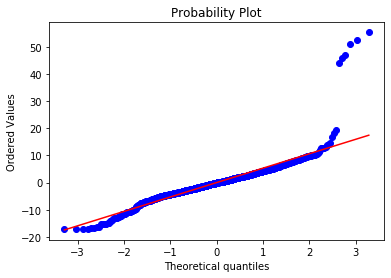

In [152]:
qqplot(b, X_train[DEP_VARS], y_train)

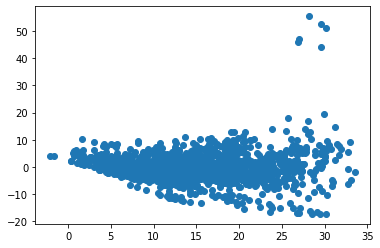

In [153]:
resid_vs_fit(b, X_train[DEP_VARS], y_train)